# Emprical Asset Pricing - Problem Set 1

Group Member: Victor Xiao, Zi Wang, Sonny Song

## 1. Time-Series Predictability of returns and dividend growth

### 1.a Data Extraction and Cleaning

In [4]:
# Packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import wrds
from datetime import datetime, timedelta
import warnings
from pandas.tseries.offsets import MonthEnd
warnings.simplefilter('ignore') # 

# Setups
pd.set_option("display.max_rows", 100)

In [2]:
# Set Up WRDS connection
db = wrds.Connection(wrds_username='vince_solis') # make sure to change the username. 

Loading library list...
Done


In [5]:
def get_libraries(db, printn = False):
    """
    get list of libraries
    """

    # List all libraries in WRDS
    libs = db.list_libraries()
    libs.__class__  # Notice that libs is a list.
    libs = pd.DataFrame({'libraries': libs})  # Transform libs to a Pandas data frame to have a better display.
    libs = libs.sort_values(['libraries']).reset_index(drop = True)
    
    # https://wrds-www.wharton.upenn.edu/pages/browse-data-concept/
    if printn:
        print(libs.to_string())  # tr_mutualfunds, tr_13f, tr_13f
    else:
        return libs

def get_tables_in_library(db, library):
    """
    List of tables in a library
    """

    return db.list_tables(library=library)

In [6]:
# Get specific columns within a particular range from table dsi (daily stock indices) from library crsp_q_stock
start_date, end_date = dt.date(1945, 1, 1), dt.date(2023, 12, 31)
start_date, end_date = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

# df = db.raw_sql("SELECT date, vwretd, vwretx  FROM crsp_q_stock.dsi WHERE (date BETWEEN '{}' AND '{}')".format(start_date, end_date))
# df.head()

In [7]:
df = pd.read_csv('./data/crsp_1945-2023.csv', index_col=0)
df.index = pd.to_datetime(df.index).to_period('M')
df.head()

,vwretd,vwretx
date,,
1945-01,0.020218,0.018951
1945-02,0.064477,0.059894
1945-03,-0.039177,-0.043164
1945-04,0.078232,0.076981
1945-05,0.018185,0.012439


In [8]:
ff = pd.read_csv('./data/F-F_Rf.csv', infer_datetime_format=True, index_col=0)
ff.index = pd.to_datetime(ff.index).to_period('M')
ff.head()

,rf
date,
1926-07,0.22
1926-08,0.25
1926-09,0.23
1926-10,0.32
1926-11,0.31


### 1.b Computing monthly dividend

$$ 
\frac{D_t}{P_t} = \frac{P_{t+1} + D_{t+1}}{P_t} -  \frac{P_{t+1}}{P_t} \quad \Rightarrow \quad D_t = \frac{D_t}{P_t} \times P_t 
$$


In [9]:
df['dividend_ret'] = df['vwretd'] - df['vwretx']
df.head()

,vwretd,vwretx,dividend_ret
date,,,
1945-01,0.020218,0.018951,0.001267
1945-02,0.064477,0.059894,0.004583
1945-03,-0.039177,-0.043164,0.003987
1945-04,0.078232,0.076981,0.001251
1945-05,0.018185,0.012439,0.005746


Constructing a price index, here we set the intial price as 1

In [10]:
df['price_index'] = (1 + df['vwretd']).cumprod()
# df['price_index'] = df['price_index']*10
df.head()

,vwretd,vwretx,dividend_ret,price_index
date,,,,
1945-01,0.020218,0.018951,0.001267,1.020218
1945-02,0.064477,0.059894,0.004583,1.085999
1945-03,-0.039177,-0.043164,0.003987,1.043452
1945-04,0.078232,0.076981,0.001251,1.125084
1945-05,0.018185,0.012439,0.005746,1.145543


In [11]:
df['dividend'] = df['dividend_ret'] * df['price_index'].shift(1)
df.fillna(method='bfill',inplace=True)

### 1.c Aggregating dividends

We assume dividend being reinvested at risk-free rate and alternatively into aggregate stock market. 

In [12]:
df_temp = df.merge(ff, left_index=True, right_index=True)
df_temp.head()

,vwretd,vwretx,dividend_ret,price_index,dividend,rf
date,,,,,,
1945-01,0.020218,0.018951,0.001267,1.020218,0.004676,0.03
1945-02,0.064477,0.059894,0.004583,1.085999,0.004676,0.02
1945-03,-0.039177,-0.043164,0.003987,1.043452,0.004330,0.02
1945-04,0.078232,0.076981,0.001251,1.125084,0.001305,0.03
1945-05,0.018185,0.012439,0.005746,1.145543,0.006465,0.03


In [13]:
# transfer the risk free rate to numarical and adjust the scale
df_temp['rf'] = pd.to_numeric(df_temp['rf'], errors='coerce')/100
df_temp['compound_month'] = 12 - df_temp.index.month
df_temp.head()

,vwretd,vwretx,dividend_ret,price_index,dividend,rf,compound_month
date,,,,,,,
1945-01,0.020218,0.018951,0.001267,1.020218,0.004676,0.0003,11
1945-02,0.064477,0.059894,0.004583,1.085999,0.004676,0.0002,10
1945-03,-0.039177,-0.043164,0.003987,1.043452,0.004330,0.0002,9
1945-04,0.078232,0.076981,0.001251,1.125084,0.001305,0.0003,8
1945-05,0.018185,0.012439,0.005746,1.145543,0.006465,0.0003,7


In [14]:
def compound_dividend(row, reinvestment_rate):
    """
    calculates the dividend compouned at reinvestment_rate(geometric return)
    """
    rate = row[reinvestment_rate] if reinvestment_rate == 'rf' else row['vwretd']
    months = row['compound_month']
    return row['dividend'] * ((1 + rate)** months )

In [15]:
df_temp['dividend_compounded_cash'] = df_temp.apply(compound_dividend, reinvestment_rate='rf', axis=1)
df_temp['dividend_compounded_stock'] = df_temp.apply(compound_dividend, reinvestment_rate='vwretd', axis=1)

In [16]:
df_temp

,vwretd,vwretx,dividend_ret,price_index,dividend,rf,compound_month,dividend_compounded_cash,dividend_compounded_stock
date,,,,,,,,,
1945-01,0.020218,0.018951,0.001267,1.020218,0.004676,0.0003,11,0.004691,0.005827
1945-02,0.064477,0.059894,0.004583,1.085999,0.004676,0.0002,10,0.004685,0.008734
1945-03,-0.039177,-0.043164,0.003987,1.043452,0.004330,0.0002,9,0.004338,0.003022
1945-04,0.078232,0.076981,0.001251,1.125084,0.001305,0.0003,8,0.001308,0.002385
1945-05,0.018185,0.012439,0.005746,1.145543,0.006465,0.0003,7,0.006478,0.007334
...,...,...,...,...,...,...,...,...,...
2023-08,-0.020300,-0.022082,0.001782,3772.627863,6.862124,0.0045,4,6.986478,6.321658
2023-09,-0.048003,-0.049226,0.001223,3591.530408,4.613924,0.0043,3,4.673700,3.980862
2023-10,-0.029225,-0.030265,0.001040,3486.567932,3.735192,0.0047,2,3.770385,3.520060


### 1.d Construct non-overlapping annual returns, annual dividend growth, log price dividend ratio for cash invested and market-invested dividend. 

In [17]:
df_temp['year'] = df_temp.index.year

# Compute Compounded Annual Returns for vwretx
compounded_annual_returns_dv = df_temp.groupby('year')['vwretd'].apply(lambda x: (x + 1).prod() - 1)

# Compute Compounded Annual Returns for vwretx
compounded_annual_returns_xdv = df_temp.groupby('year')['vwretx'].apply(lambda x: (x + 1).prod() - 1)

# Adjusting calculations for annual dividends and their growth
annual_div_zero = df_temp.groupby('year')['dividend'].sum()
annual_div_cash = df_temp.groupby('year')['dividend_compounded_cash'].sum()
annual_div_stock = df_temp.groupby('year')['dividend_compounded_stock'].sum()

# Calculate annual dividend growth as the percentage difference (year-over-year change)
dg_zero = annual_div_zero.pct_change()
dg_cash = annual_div_cash.pct_change()
dg_stock = annual_div_stock.pct_change()

price_index_annual = df_temp.groupby('year')['price_index'].last()

log_price_dividend_ratio_zero = np.log(price_index_annual / annual_div_zero)
log_price_dividend_ratio_cash = np.log(price_index_annual / annual_div_cash)
log_price_dividend_ratio_stock = np.log(price_index_annual / annual_div_cash)

# Creating a new DataFrame to hold all calculated data
annual_df = pd.DataFrame({
    'ret_dv': compounded_annual_returns_dv,
    'ret_xdv': compounded_annual_returns_xdv,
    'dg_Zero': dg_zero,
    'dg_Cash': dg_cash,
    'dg_Stock': dg_stock,
    'Log_PD_Zero': log_price_dividend_ratio_zero,
    'Log_PD_Cash': log_price_dividend_ratio_cash,
    'Log_PD_Stock': log_price_dividend_ratio_stock
})

# Resetting index to have 'year' as a column
annual_df.reset_index(inplace=True)

In [18]:
annual_df.describe().round(4)

,year,ret_dv,ret_xdv,dg_Zero,dg_Cash,dg_Stock,Log_PD_Zero,Log_PD_Cash,Log_PD_Stock
count,79.0000,79.0000,79.0000,78.0000,78.0000,78.0000,79.0000,79.0000,79.0000
mean,1984.0000,0.1252,0.0893,0.0980,0.0984,0.1039,3.5697,3.5536,3.5536
std,22.9492,0.1745,0.1684,0.0764,0.0783,0.1458,0.4266,0.4298,0.4298
min,1945.0000,-0.3833,-0.3976,-0.1443,-0.1513,-0.1630,2.7692,2.7657,2.7657
25%,1964.5000,0.0023,-0.0334,0.0590,0.0603,-0.0041,3.2646,3.2395,3.2395
50%,1984.0000,0.1556,0.1179,0.0872,0.0893,0.0886,3.5153,3.5030,3.5030
75%,2003.5000,0.2518,0.2177,0.1278,0.1315,0.1834,3.9439,3.9417,3.9417
max,2023.0000,0.5041,0.4336,0.3206,0.3204,0.6310,4.4851,4.4649,4.4649


In [19]:
# compute mean and volatility
mean_growth_cash = annual_df['dg_Cash'].mean()
volatility_growth_cash = annual_df['dg_Cash'].std()
mean_growth_market = annual_df['dg_Stock'].mean()
volatility_growth_market = annual_df['dg_Stock'].std()

print(f"Dividend growth mean_reinvest in cash market: {mean_growth_cash}")
print(f"Dividend growth volatility_reinvest in cash market: {volatility_growth_cash}")
print(f"Dividend growth mean_reinvest in stock market: {mean_growth_market}")
print(f"Dividend growth volatility_reinvest in stock market: {volatility_growth_market}")

Dividend growth mean_reinvest in cash market: 0.09844036884563737
Dividend growth volatility_reinvest in cash market: 0.07833731315087886
Dividend growth mean_reinvest in stock market: 0.10387231928764912
Dividend growth volatility_reinvest in stock market: 0.1457956908109608


Discussion: The mean dividend growth when reinvested in the stock market reflects the equity risk premium—the additional return over the risk-free rate investors expect for taking on the higher uncertainty of stock investments. The stock market's higher mean growth is essentially the market compensating investors for this higher risk.

Volatility in dividend growth for market-invested dividends being greater than cash-invested dividends aligns with financial theories that posit that stocks are more volatile than risk-free assets. This is observable empirically through greater dispersion in stock returns due to a myriad of factors influencing stock prices, such as company performance, economic changes, and investor sentiment.

### 1.e Predict log returns and log dividend growth using the lagged log price-dividend ratio. 

In [20]:
import statsmodels.api as sm

# Assuming 'annual_df' is prepared as previously described
annual_df['Log_PD_Cash_Lagged'] = annual_df['Log_PD_Cash'].shift(1)
annual_df['Log_Return'] = np.log(1 + annual_df['ret_dv'])
annual_df['Log_Dividend_Growth'] = np.log(1 + annual_df['dg_Cash'])

# Dropping NaN values that result from lagging
annual_df.dropna(inplace=True)

In [21]:
def run_regression_sm(data, dependent_var, independent_var):
    # Adding a constant to the independent variable for the intercept
    X = sm.add_constant(data[independent_var])
    y = data[dependent_var]
    
    model = sm.OLS(y, X).fit()
    print(model.summary())

In [22]:
def regress_and_report(data, dependent_var, independent_var, sub_sample=None):
    data_copy = data.copy()
    if sub_sample is not None:
        data_copy = data_copy[(data_copy['Year'] >= sub_sample[0]) & (data_copy['Year'] <= sub_sample[1])]

    lagged_var = 'lagged_' + independent_var
    data_copy[lagged_var] = data_copy[independent_var].shift(1)

    data_copy.dropna(subset=[lagged_var], inplace=True)

    X = sm.add_constant(data_copy[lagged_var])
    y = data_copy[dependent_var]

    model = sm.OLS(y, X).fit()

    return {
        'coefficients': model.params,
        'R_squared': model.rsquared,
        'model_summary': model.summary()
    }

In [23]:
results_return_full = regress_and_report(
    annual_df,
    'Log_Return',
    'Log_PD_Cash_Lagged',
    sub_sample=None
)

# For predicting cash-invested dividend growth using the lagged log price-dividend ratio:
results_div_growth_full = regress_and_report(
    annual_df,
    'Log_Dividend_Growth',
    'Log_PD_Cash_Lagged',
    sub_sample=None
)

In [24]:
print("Full Sample Regression Analysis")
print(f"\nPredicting Returns:{results_return_full['model_summary']}")

Full Sample Regression Analysis

Predicting Returns:                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.779
Date:                Tue, 26 Mar 2024   Prob (F-statistic):             0.0319
Time:                        02:48:14   Log-Likelihood:                 32.308
No. Observations:                  77   AIC:                            -60.62
Df Residuals:                      75   BIC:                            -55.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [25]:
print("Full Sample Regression Analysis")
print(f"\nPredicting Dividend Growth:{results_div_growth_full['model_summary']}")

Full Sample Regression Analysis

Predicting Dividend Growth:                             OLS Regression Results                            
Dep. Variable:     Log_Dividend_Growth   R-squared:                       0.065
Model:                             OLS   Adj. R-squared:                  0.052
Method:                  Least Squares   F-statistic:                     5.172
Date:                 Tue, 26 Mar 2024   Prob (F-statistic):             0.0258
Time:                         02:48:14   Log-Likelihood:                 97.172
No. Observations:                   77   AIC:                            -190.3
Df Residuals:                       75   BIC:                            -185.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

#### Sub-sample regression

In [26]:
# Perform regression analysis for the sub-samples (1945-1990 and 1990-2021)
for start_year, end_year in [(1945, 1990), (1990, 2021)]:
    sub_df = annual_df[(annual_df['year'] >= start_year) & (annual_df['year'] <= end_year)]
    
    print(f"\nSub-sample: {start_year}-{end_year} Regression Analysis")
    print("\nPredicting Returns:")
    run_regression_sm(sub_df, 'Log_Return', 'Log_PD_Cash_Lagged')

    print("\nPredicting Dividend Growth:")
    run_regression_sm(sub_df, 'Log_Dividend_Growth', 'Log_PD_Cash_Lagged')


Sub-sample: 1945-1990 Regression Analysis

Predicting Returns:
                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     13.31
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           0.000708
Time:                        02:48:16   Log-Likelihood:                 26.397
No. Observations:                  45   AIC:                            -48.79
Df Residuals:                      43   BIC:                            -45.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

#### Full Report for Full Sample, 1945-1990, 1990-2021

In [27]:
def get_regression_stats_and_r2(data, dependent_var, independent_var):
    X = sm.add_constant(data[independent_var])
    y = data[dependent_var]
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    t_beta = model.tvalues[1]
    r_squared = model.rsquared
    return beta, t_beta, r_squared

# Initialize a dictionary to hold the results with R^2 values
results = {
    'Sample': ['Full Sample', '1945-1990', '1990-2021'],
    'beta_d': [],
    't_beta_d': [],
    'R2_d': [],
    'beta_r': [],
    't_beta_r': [],
    'R2_r': []
}

# Full Sample
beta_d, t_beta_d, r2_d = get_regression_stats_and_r2(annual_df, 'Log_Dividend_Growth', 'Log_PD_Cash_Lagged')
beta_r, t_beta_r, r2_r = get_regression_stats_and_r2(annual_df, 'Log_Return', 'Log_PD_Cash_Lagged')
results['beta_d'].append(beta_d)
results['t_beta_d'].append(t_beta_d)
results['R2_d'].append(r2_d)
results['beta_r'].append(beta_r)
results['t_beta_r'].append(t_beta_r)
results['R2_r'].append(r2_r)

# Sub-Samples
for start_year, end_year in [(1945, 1990), (1990, 2021)]:
    sub_df = annual_df[(annual_df['year'] >= start_year) & (annual_df['year'] <= end_year)]
    
    beta_d, t_beta_d, r2_d = get_regression_stats_and_r2(sub_df, 'Log_Dividend_Growth', 'Log_PD_Cash_Lagged')
    beta_r, t_beta_r, r2_r = get_regression_stats_and_r2(sub_df, 'Log_Return', 'Log_PD_Cash_Lagged')
    results['beta_d'].append(beta_d)
    results['t_beta_d'].append(t_beta_d)
    results['R2_d'].append(r2_d)
    results['beta_r'].append(beta_r)
    results['t_beta_r'].append(t_beta_r)
    results['R2_r'].append(r2_r)

results_df = pd.DataFrame(results)

In [28]:
results_df

,Sample,beta_d,t_beta_d,R2_d,beta_r,t_beta_r,R2_r
0,Full Sample,-0.034232,-1.840875,0.042686,-0.108912,-2.561629,0.079479
1,1945-1990,-0.082343,-2.337006,0.112700,-0.315011,-3.648901,0.236431
2,1990-2021,0.056158,1.034359,0.034435,-0.194368,-1.765157,0.094087


### 1.f Campbell-Shiller Identify

$$
    pd_{t+1} = a_{pd} + \phi pd_t + \epsilon^{pd}_{t+1}
$$

In [29]:
X = sm.add_constant(annual_df['Log_PD_Cash_Lagged'][1:])
y = annual_df['Log_PD_Cash'][1:]

model_pd = sm.OLS(y, X).fit()
print(F'AR(1) Model for Log Price-Dividend Ratio::{model_pd.summary()}')

AR(1) Model for Log Price-Dividend Ratio::                            OLS Regression Results                            
Dep. Variable:            Log_PD_Cash   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     396.9
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           1.11e-31
Time:                        02:48:21   Log-Likelihood:                 26.758
No. Observations:                  77   AIC:                            -49.52
Df Residuals:                      75   BIC:                            -44.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [30]:
#compute pd_mean and rho
pd_mean = annual_df['Log_PD_Cash'].mean()
rho = np.exp(pd_mean)/(1+np.exp(pd_mean))
rho

0.9722687688693198

In [31]:
phi = model_pd.params[1]  # This is the estimated φ from the AR(1) model.

b_r = -0.108912 # Coefficient from return predictability regression
b_d = -0.034232  # Coefficient from dividend growth predictability regression

discount_rate_news = -b_r / (1 - rho * phi) * annual_df['Log_PD_Cash']
cash_flow_news = b_d / (1 - rho * phi) * annual_df['Log_PD_Cash']

Divide both side by $Var(pd_t)$ to estimate how much variation is due to discount rate news and cash flow news

In [32]:
var_pd = annual_df['Log_PD_Cash'].var()
cov_cash_flow = np.cov(cash_flow_news, annual_df['Log_PD_Cash'])[0, 1]
cov_discount_rate = np.cov(discount_rate_news, annual_df['Log_PD_Cash'])[0, 1]

In [33]:
discount_rate_proportion = cov_discount_rate / var_pd
cash_flow_proportion = cov_cash_flow / var_pd

print("Variance Decomposition:")
print("Proportion due to Discount Rate News:", discount_rate_proportion)
print("Proportion due to Cash Flow News:", cash_flow_proportion)

Variance Decomposition:
Proportion due to Discount Rate News: 1.0518804558943198
Proportion due to Cash Flow News: -0.33061528358834963


Alternatively,
$$
\begin{align*}

    pd_t &= b_d \sum^{\infty}_{t=1} \rho^{t-1}\phi^{t-1} pd_t - b_r \sum^{\infty}_{t=1} \rho^{t-1}\phi^{t-1} pd_t \\
    1 &= \frac{b_d}{1-\rho\phi} + \frac{-b_r}{1-\rho\phi} 

\end{align*}
$$

This means that we can write

$$
\begin{align*}
    b_d &= (1 + \frac{b_r}{1-\rho\phi}) * (1 - \rho\phi) \\
       &= 1 - \rho\phi + b_r \\
    b_r &= (\frac{b_d}{1-\rho\phi} - 1)* (1 - \rho\phi) \\
        &= b_d - 1 + \rho\phi \\

\end{align*}
$$

### 1.g The present-value identity implies restrictions between $b_r$, $b_d$ and $\phi$. Derive the connection between the coefficients. 

The variance decomposition of the log price-dividend ratio ($pd_t$) involves understanding how variations in $pd_t$ can be explained by expected future dividends ($\Delta d_{t+s}$), expected future returns ($r_{t+s}$), and the autocorrelation of $pd_t$ itself. The formula provided can be interpreted as follows:

$$
\text{Var}(pd_t) = \text{Cov}\left(\sum_{s=1}^{\infty} \rho^{s-1}E_t[\Delta d_{t+s}], pd_t\right) + \text{Cov}\left(-\sum_{s=0}^{\infty} \rho^{s-1}E_t[r_{t+s}], pd_t\right) + \text{Cov}(pd_t, \rho pd_{t-1})
$$

Given that $pd_t = \phi pd_{t-1}$, and assuming stationarity, we have:

$$
\text{Cov}(pd_t, \rho pd_{t-1}) \Rightarrow \text{Cov}(\phi pd_{t-1}, \rho pd_{t-1}) \Rightarrow \rho \phi \text{Var}(pd_{t-1}) \Rightarrow \rho \phi \text{Var}(pd_t)
$$

Dividing both sides by $\text{Var}(pd_t)$, we obtain:

$$
1 = \frac{\text{Cov}\left(\sum_{s=1}^{\infty} \rho^{s-1}E_t[\Delta d_{t+s}], pd_t\right)}{\text{Var}(pd_t)} + \frac{\text{Cov}\left(-\sum_{s=0}^{\infty} \rho^{s-1}E_t[r_{t+s}], pd_t\right)}{\text{Var}(pd_t)} + \frac{\rho \phi \cdot \text{Var}(pd_t)}{\text{Var}(pd_t)}
$$

Simplifying further, we get:

$$
1 - \rho \phi = b_d - b_r
$$

where $b_d$ and $b_r$ represent the contributions to the variance of $pd_t$ from "cash flow" and "discount rate", respectively.

#### 1.h Predict cumulative returns using lagged PD for n = {1, ..., 5}. Is there more predictability over longer horizons?

In [35]:
annual_dfa = annual_df.copy()
for i in range(1,6):
    annual_dfa[f'ret_{i}'] = annual_dfa['Log_Return'].rolling(window=i).sum().shift(-i)
    annual_dfa[f'div_{i}'] = annual_dfa['Log_Dividend_Growth'].rolling(window=i).sum().shift(-i)

def test_predictability(df):
    
    df = df.dropna()
    result = {}
    for i in range(1,6):
        X = df['Log_PD_Cash']
        X = sm.add_constant(X)
        
        Y_return = df[f"ret_{i}"]
        Y_div = df[f"div_{i}"]
        
        model_ret = sm.OLS(Y_return, X).fit()
        model_div = sm.OLS(Y_div, X).fit()
        
        return_coef = model_ret.params.loc['Log_PD_Cash']
        return_sr = model_ret.bse.iloc[1]
        return_r_squared = model_ret.rsquared
        
        div_coef = model_div.params.loc['Log_PD_Cash']
        div_sr = model_div.bse.iloc[1]
        div_r_squared = model_div.rsquared
        
        result[i] = [return_coef, return_sr, return_r_squared, div_coef, div_sr, div_r_squared]
    
    column_names = ['ret_coef', 'ret_sr', 'ret_r_squared', 'div_coef', 'div_sr', 'div_r_squared']
    res_2 = pd.DataFrame.from_dict(result, orient='index',columns=column_names)
    
    return res_2
        
result = test_predictability(annual_dfa)
result 

,ret_coef,ret_sr,ret_r_squared,div_coef,div_sr,div_r_squared
1,-0.117956,0.044369,0.090535,-0.034726,0.020078,0.040428
2,-0.218221,0.057393,0.169172,-0.078650,0.031699,0.079788
3,-0.272650,0.061091,0.219079,-0.111881,0.040380,0.097575
4,-0.334896,0.064768,0.273555,-0.134021,0.046243,0.105787
5,-0.429232,0.071530,0.336503,-0.134806,0.049639,0.094099


### 1.i Assume log pd ratio follow AR(1), derive the connection between the coefficients $b_{r,n}$, $b_{d,n}$ and $\phi$.

From Shiller's identity, we have 

$$
\begin{align*}
    pd_t &= \kappa_0 + \Delta_{t+1} - r_{t+1} + \kappa_1pd_{t+1} \\
    \sum^n_{j=1} pd_{t+j-1} &= n\kappa_0 + \sum_{j=1}^n \Delta d_{t+j} - \sum^n_{j=1} r_{t+j} + \kappa_1 \sum^n_{j=1} pd_{t+j} \\
    Cov(\sum^n_{j=1}pd_{t+j-1}, pd_t) &= Cov(\sum^n_{j=1}\delta d_{t+j}, pd_t) - Cov(\sum^n_{j=1}r_{t+j}, pd_t) + \kappa_1 Cov(\sum^n_{j=1}pd_{t+j}, pd_t) \\
    Cov(\sum^n_{j=1}pd_{t+j-1}, pd_t) &= Cov(\sum^n_{j=1}\delta d_{t+j}, pd_t) - Cov(\sum^n_{j=1}r_{t+j}, pd_t) + \kappa_1 \sum^n_{j=1} Cov(pd_{t+j}, pd_t) 
\\
\end{align*}
$$

Given $pd_t$ follow an AR(1), we have:

$$
Cov(pd_{t+k}, pd_t) = \phi^k Var(pd_t)
$$

Then we can write:

$$
\begin{align}
\sum^n_{j=1} Cov(pd_{t+j-1}, pd_t) &= (1 + \phi^1 + ... + \phi^{n-1}) Var(pd_t) = \frac{1 - \phi^n}{1 - \phi} Var(pd_t) \\

\sum^n_{j=1} Cov(pd_{t+j}, pd_t) &= (\phi^1 + \phi^2 + ... + \phi^{n}) Var(pd_t) = \phi \frac{1 - \phi^n}{1 - \phi} Var(pd_t) 
\end{align}
$$


This means we can derive the main equation with:

$$
\begin{align*}
    \frac{1 - \phi^n}{1 - \phi} (1 - \kappa_1 \phi) Var(pd_t) &= Cov(\sum^n_{j=1}\Delta_{t+j}, pd_t)- Cov(\sum^n_{j=1}r_{t+j}, pd_t) \\
    \frac{1 - \phi^n}{1 - \phi} (1 - \kappa_1 \phi) &= \frac{Cov(\sum^n_{j=1}\Delta_{t+j}, pd_t)}{Var(pd_t)} - \frac{Cov(\sum^n_{j=1}r_{t+j}, pd_t)}{Var(pd_t)} \\
\end{align*}
$$

Matching definitition for our regression equations we have:

$$
\begin{align*}
    b_{d,n}\frac{Cov(\sum^n_{j=1}\Delta_{t+j}, pd_t)}{Var(pd_t)} \\

    b_{r,n} = \frac{Cov(\sum^n_{j=1}r_{t+j}, pd_t)}{Var(pd_t)} 
\end{align*}
$$

Which yields the connections between the coeffcients as:

$$
     b_{d, n} - b_{r,n} = \frac{1-\phi^n}{1-\phi}(1-\kappa_1\phi)
$$

## 2. The Mankiw-Shapiro and Stambaugh bias

### 2.a (1) Regress log annual return to log price-dividend with lag

In [36]:
annual_df2 = annual_df.copy()
# annual_df2['Log_PD_Lagged'] = annual_df2['Log_PD_Cash'].dropna()
annual_df2 = annual_df2[['Log_PD_Cash','Log_PD_Cash_Lagged','Log_Return']].dropna()

X = sm.add_constant(annual_df2['Log_PD_Cash_Lagged'])
y = annual_df['Log_Return']

model_ret = sm.OLS(y, X).fit()
print(F'Model for Log Annual Return to Price-Dividend Ratio::{model_ret.summary()}')

Model for Log Annual Return to Price-Dividend Ratio::                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     6.562
Date:                Tue, 26 Mar 2024   Prob (F-statistic):             0.0124
Time:                        02:50:28   Log-Likelihood:                 33.514
No. Observations:                  78   AIC:                            -63.03
Df Residuals:                      76   BIC:                            -58.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

#### (2) Regress log price dividend ratio to log price-dividend with lag

$$
pd_{t+1} = a{pd} + \phi pd_t + \epsilon^{pd}_{t+1}
$$

In [37]:
X = sm.add_constant(annual_df2['Log_PD_Cash_Lagged'])
y = annual_df['Log_PD_Cash']

model_ar1 = sm.OLS(y, X).fit()
print(F'Model for Log Annual Return to Price-Dividend Ratio::{model_ar1.summary()}')

Model for Log Annual Return to Price-Dividend Ratio::                            OLS Regression Results                            
Dep. Variable:            Log_PD_Cash   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     401.6
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           4.62e-32
Time:                        02:50:32   Log-Likelihood:                 27.075
No. Observations:                  78   AIC:                            -50.15
Df Residuals:                      76   BIC:                            -45.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [38]:
residuals_ret = model_ret.resid
residuals_ar = model_ar1.resid

# covariance-matrix
cov_matrix_error = pd.DataFrame([[residuals_ret.cov(residuals_ret), residuals_ret.cov(residuals_ar)],
                                  [residuals_ar.cov(residuals_ret), residuals_ar.cov(residuals_ar)]],
                                 columns=['residuals_ret', 'residuals_ar'],
                                 index=['residuals_ret', 'residuals_ar'])

# Display the covariance matrix DataFrame
print(cov_matrix_error)

               residuals_ret  residuals_ar
residuals_ret       0.025115      0.024967
residuals_ar        0.024967      0.029623


### 2.b Generate samples

In [39]:
annual_df3 = annual_df.copy()
annual_df3 = annual_df3[['Log_PD_Cash','Log_Return']].dropna()

In [40]:
def generate_single_sample(df, a_r, b_r, a_pd, phi, cov_matrix_error):
    
    ret_mean = df['Log_Return'].mean()
    pd_mean = df['Log_PD_Cash'].mean()
    ret_std = df['Log_Return'].std()
    pd_std = df['Log_PD_Cash'].std()
    
    
    single_sample = np.zeros((69,4))
    error_sample = np.random.multivariate_normal(mean=[0, 0], cov=cov_matrix_error, size=69)
    single_sample[:,2:4] = error_sample
    single_sample[0,0] = np.random.normal(loc = ret_mean, scale = ret_std, size=(1, 1))
    single_sample[0,1] = np.random.normal(loc = pd_mean, scale = pd_std, size=(1, 1))
    
    for i in range(1,69):
        # Log_Return
        single_sample[i,0] = a_r + b_r * single_sample[i-1,1] + single_sample[i,2]
        # price to dividend ratio
        single_sample[i,1] = a_pd + phi * single_sample[i-1,1] + single_sample[i,3]
    column_names = ['Log_Return', 'Log_PD_Cash', 'Log_Return_resi', 'Log_PD_Cash_resi']
    result = pd.DataFrame(single_sample, columns=column_names)
    result['Log_PD_Cash_Lagged'] = result['Log_PD_Cash'].shift(1)
    return result.dropna()

In [41]:
b_r = model_ret.params.loc['Log_PD_Cash_Lagged']
a_r = model_ret.params.loc['const']
phi = model_ar1.params.loc['Log_PD_Cash_Lagged']
a_pd = model_ar1.params.loc['const']
generate_single_sample(annual_df3, a_r, b_r, a_pd, phi, cov_matrix_error)

,Log_Return,Log_PD_Cash,Log_Return_resi,Log_PD_Cash_resi,Log_PD_Cash_Lagged
1,0.148713,3.594378,0.055660,-0.040078,3.629948
2,0.038075,3.432124,-0.058852,-0.169419,3.594378
3,0.214710,3.582226,0.100112,0.130820,3.432124
4,0.002297,3.552030,-0.095953,-0.038267,3.582226
5,0.022052,3.511141,-0.079487,-0.051217,3.552030
6,0.142099,3.499411,0.036107,-0.025110,3.511141
7,0.314210,3.696941,0.206940,0.183273,3.499411
8,0.093388,3.821762,0.007631,0.125317,3.696941
9,0.062603,3.753237,-0.009559,-0.058708,3.821762
10,0.512727,4.206447,0.433102,0.457909,3.753237


#### Simulate 10000 times

In [42]:

def get_coef(df, a_r, b_r, a_pd, phi, cov_matrix_error,n=10000):
    np.random.seed(42)
    b_r_list = []
    phi_list = []
    for i in range(n): 
        sample = generate_single_sample(df, a_r, b_r, a_pd, phi, cov_matrix_error)
        
        X = sample['Log_PD_Cash_Lagged']
        X = sm.add_constant(X)
        Y1 = sample['Log_PD_Cash']
        model1 = sm.OLS(Y1, X).fit()
        phi_temp = model1.params.loc['Log_PD_Cash_Lagged']
        phi_list.append(phi_temp)
        
        X = sample['Log_PD_Cash_Lagged']
        X = sm.add_constant(X)
        Y2 = sample['Log_Return']
        model2 = sm.OLS(Y2, X).fit()
        b_r_temp = model2.params.loc['Log_PD_Cash_Lagged']
        b_r_list.append(b_r_temp)     
        
    phi_mean = sum(phi_list) / len(phi_list)
    b_r_mean = sum(b_r_list) / len(b_r_list)
    
    result = {
    'Population': [b_r, phi],
    'coef': [b_r_mean, phi_mean]
    }
    
    result_df = pd.DataFrame(result, index=['b_r','phi'])
    
    return result_df

In [43]:
result_1 = get_coef(annual_df2, a_r, b_r, a_pd, phi, cov_matrix_error,10000)
result_1

,Population,coef
b_r,-0.108912,-0.161119
phi,0.925319,0.863180


### 2.c Setting the covariance to 0. 

In [44]:
cov_matrix_error2 = cov_matrix_error.copy()
cov_matrix_error2.iloc[0,1],cov_matrix_error2.iloc[1,0]=0,0
# cov_matrix_error2.iloc[1,0]=0
cov_matrix_error2

result_2 = get_coef(annual_df2, a_r, b_r, a_pd, phi, cov_matrix_error2)
result_2

,Population,coef
b_r,-0.108912,-0.108174
phi,0.925319,0.863456


Discussion: the $\hat{b_r}$, $\hat{\phi}$ model estimate changed from -0.1611 to -0.1082, and became much closer to the population $b_r$ and $\hat{\phi}$. This means that the contribution from the varince of discount rate became much more pronounced if the covariance of the shocks $Cov(\epsilon^r_{t+1}, \epsilon^{pd}_{t+1}) = 0$ 

### 2.d

In [45]:
def calc_bias(df, a_r, b_r, a_pd, phi, cov_matrix_error,n=10000):
    lambda_list = [i/10 for i in range(11)]
    result = {"lambda":lambda_list,
              "b_r":[],
             "phi":[],
             "b_r_bias":[],
             "phi_bias":[]}
    
    for l in lambda_list:
        phi_new = l * phi
        phi_list = []
        b_r_list = []
        for i in range(n):
            sample = generate_single_sample(df, a_r, b_r, a_pd, phi_new, cov_matrix_error)

            X = sample['Log_PD_Cash_Lagged']
            X = sm.add_constant(X)
            Y1 = sample['Log_PD_Cash']
            model1 = sm.OLS(Y1, X).fit()
            phi_temp = model1.params.loc['Log_PD_Cash_Lagged']
            phi_list.append(phi_temp)

            X = sample['Log_PD_Cash_Lagged']
            X = sm.add_constant(X)
            Y2 = sample['Log_Return']
            model2 = sm.OLS(Y2, X).fit()
            b_r_temp = model2.params.loc['Log_PD_Cash_Lagged']
            b_r_list.append(b_r_temp)     

        
        
        result['b_r'].append(sum(b_r_list) / len(b_r_list))
        result['phi'].append(sum(phi_list) / len(phi_list))
        result['b_r_bias'].append(sum(b_r_list) / len(b_r_list) - b_r)
        result['phi_bias'].append(sum(phi_list) / len(phi_list) - phi_new)
        
    result = pd.DataFrame(result)
        
    return result

In [46]:
result_final = calc_bias(annual_df2, a_r, b_r, a_pd, phi, cov_matrix_error,n=10000)    
result_final

,lambda,b_r,phi,b_r_bias,phi_bias
0,0.0,-0.110739,-0.002172,-0.001827,-0.002172
1,0.1,-0.111075,0.089935,-0.002162,-0.002597
2,0.2,-0.112287,0.180958,-0.003375,-0.004105
3,0.3,-0.113673,0.271960,-0.004761,-0.005636
4,0.4,-0.114508,0.363667,-0.005596,-0.006461
5,0.5,-0.114359,0.456200,-0.005447,-0.006459
6,0.6,-0.115645,0.547230,-0.006733,-0.007962
7,0.7,-0.117575,0.637700,-0.008663,-0.010023
8,0.8,-0.120064,0.727297,-0.011151,-0.012959
9,0.9,-0.126443,0.811929,-0.017531,-0.020859


Text(0, 0.5, 'Bias')

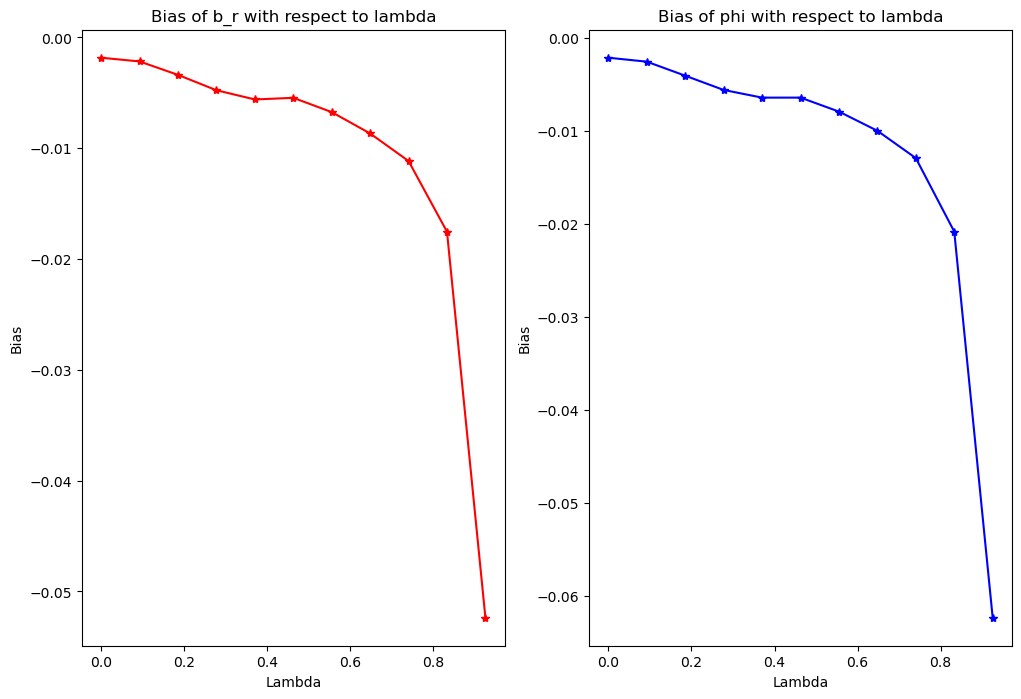

In [48]:
lambda_list = [i/10 for i in range(11)]
phi_new = [l * phi for l in lambda_list]
# plot the bias
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(phi_new, np.array(result_final['b_r_bias']), marker='*', color='r')
plt.title("Bias of b_r with respect to lambda")
plt.xlabel("Lambda")
plt.ylabel("Bias")

plt.subplot(1, 2, 2)
plt.plot(phi_new, np.array(result_final['phi_bias']), marker='*', color='b')
plt.title("Bias of phi with respect to lambda")
plt.xlabel("Lambda")
plt.ylabel("Bias")

Discussion: We can observe that the bias of $b_r$ and $\phi$ became larger in magnitude as the $\lambda$ parameter is adjusted higher. This likely means that when we increase the effect of the persistence parameter $\phi$, we also increase estimation bias.